In [58]:
from scipy import *
import WLanalysis
import cPickle as pickle
import camb
from camb import model, initialpower
from astropy.cosmology import FlatLambdaCDM
from scipy import optimize,stats
import os 
import numpy as np
import sys
import astropy.units as u
from scipy import interpolate
from scipy.integrate import quad
from IPython.display import Image

In [2]:
fn_list = genfromtxt('cosmo_params_all.txt',usecols=1, dtype='string')
fidu_cosmo = fn_list[0]

In [4]:
params = genfromtxt('cosmo_params_all.txt',usecols=[2,3,4,5]) #M_nu Omega_m 10^9*A_s sigma_8

In [6]:
z_source = arange(0.5,3,0.5)
ps_arr = array([[mean(load('powerspectrum_noiseless/%s_PS_50_z%02d.npy'%(icosmo,iz*10))[1:],axis=0) for icosmo in fn_list] for iz in z_source])
#save('ps_arr.npy', ps_arr)
#ps_arr = load('ps_arr.npy')
ps_fidu = array([load('powerspectrum_noisy/%s_PS_50_z%02d.npy'%(fidu_cosmo,iz*10))[1:]  for iz in z_source])
ell_fidu = array([load('powerspectrum_noisy/%s_PS_50_z%02d.npy'%(fidu_cosmo,iz*10))[0]  for iz in z_source])
ds = pickle.load(open("pickled_derivatives_powers.pkl",'rb'))

In [7]:
ell_mat = arange(5000)
#{'tau': 0.06, 'H0': 67.0, 'mnu': 0.1, 'As': 2.2e-09, 'omch2': 0.1247, 'w0': -1.0, 'ns': 0.96, 'ombh2': 0.0223}
#{'tau': 0.00, 'H0': 70.0, 'mnu': 0.1, 'As': 2.1e-09, 'omch2': 0.1247, 'w0': -1.0, 'ns': 0.97, 'ombh2': 0.0223}
#ds['As'][0,0].shape 
#ds['mnu'][0,0] is dC00/dmnu
#Clnn=0.35**2 / ngal / 1.18e7
#dCell/dmnu = (C(mnu+step/2.)-(mnu-step/2.))/step
dcldmnu_mat = array([ds['mnu'][i,i] for i in range(5)])
dcldmnu_mat.shape

(5, 5000)

In [8]:
print ps_arr.shape, params.shape,ps_fidu.shape, ell_fidu.shape

(5, 101, 50) (101, 4) (5, 1000, 50) (5, 50)


In [9]:
ps_all = [WLanalysis.buildInterpolator(ps_arr[i], params[:,:-1]) for i in range(5)]

In [10]:
ps_fidu_avg = mean(ps_fidu,axis=1)
ps_fidu_avg.shape

(5, 50)

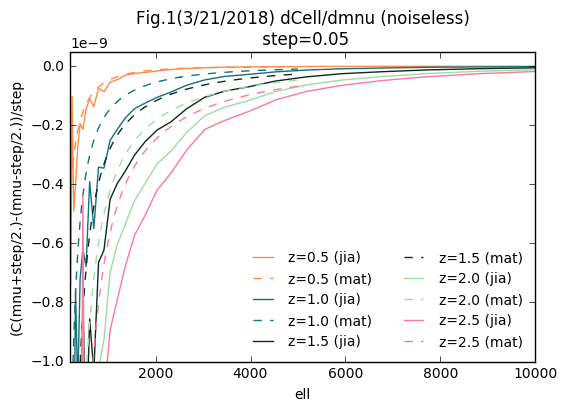

In [11]:
istep = 0.05
ps_hi = array ( [ps_all[i]( (0.1 * (1+istep/2), 0.3, 2.1))  for i in range(5)])
ps_lo = array ( [ps_all[i]( (0.1 * (1-istep/2), 0.3, 2.1))  for i in range(5)])
dcldmnu_jia = (ps_hi - ps_lo)/(0.1*istep)

f,ax=subplots(1,1,figsize=(6,4))
seed(45)
for i in range(5):
    icolor=rand(3)
    ax.plot(ell_fidu[i], dcldmnu_jia[i],'-',color=icolor,label='z=%s (jia)'%(z_source[i]))
    ax.plot(ell_mat, dcldmnu_mat[i],'--',color=icolor,label='z=%s (mat)'%(z_source[i]))
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(200,1e4)
#ax.set_ylim(-0.8e-8,0.2e-8)
ax.set_ylim(-1e-9,0.5e-10)
ax.legend(loc=0,frameon=0,fontsize=10,ncol=2)
ax.set_xlabel('ell')
ax.set_ylabel('(C(mnu+step/2.)-(mnu-step/2.))/step')
ax.set_title('Fig.1(3/21/2018) dCell/dmnu (noiseless)\n step=%s'%(istep))
show()

In [116]:
istep = 0.05
ps_hi = array ( [ps_all[i]( (0.1 * (1+istep/2), 0.3, 2.1))  for i in range(5)])
ps_lo = array ( [ps_all[i]( (0.1 * (1-istep/2), 0.3, 2.1))  for i in range(5)])
dcldmnu_jia = (ps_hi - ps_lo)/(0.1*istep)
tomat = concatenate( [ell_fidu[i].reshape(1,-1), dcldmnu_jia])
save('dcldmnu_jia.npy',tomat)

ps_omhi = array ( [ps_all[i]( (0.1 , 0.3* (1+istep/2), 2.1))  for i in range(5)])
ps_omlo = array ( [ps_all[i]( (0.1 , 0.3* (1-istep/2), 2.1))  for i in range(5)])
dcldom_jia = (ps_omhi - ps_omlo)/(0.3*istep)
tomat = concatenate( [ell_fidu[i].reshape(1,-1), dcldom_jia])
save('dcldom_jia.npy',tomat)

ps_Ashi = array ( [ps_all[i]( (0.1 , 0.3, 2.1* (1+istep/2)))  for i in range(5)])
ps_Aslo = array ( [ps_all[i]( (0.1 , 0.3, 2.1* (1-istep/2)))  for i in range(5)])
dcldAs_jia = (ps_Ashi - ps_Aslo)/(2.1*istep)
tomat = concatenate( [ell_fidu[i].reshape(1,-1), dcldAs_jia])
save('dcldAs_jia.npy',tomat)

In [21]:
omega_m=0.3
h=0.7
fnu = lambda mnu: mnu/93.14/omega_m/h**2

def Pkgen(mnu, fixom=1, zcamb=arange(0.0,2.5,0.5), omch2=0.1236, ombh2=0.0223,omega_m=0.3):
    pars = camb.CAMBparams()
    if fixom:
        omnu = fnu(mnu)*omega_m
        omch2 = omega_m*h**2 - omnu*h**2 - ombh2
    print 'mnu, omch2:', mnu, omch2
    pars.set_cosmology(H0=70, ombh2=ombh2, omch2=omch2, neutrino_hierarchy='normal',num_massive_neutrinos=3, mnu=mnu)
    pars.InitPower.set_params(ns=0.97, As=2.1e-9)
    pars.set_matter_power(redshifts=zcamb, kmax=10.0)
    results = camb.get_results(pars)
    ########### NL power spectrum ########
    pars.NonLinear = model.NonLinear_both
    #pars.NonLinear = model.NonLinear_none  #linear
    results.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-2, maxkh=10.0, npoints = 250)
    return kh_nonlin, z_nonlin, pk_nonlin

#out_fixom = [Pkgen(imnu) for imnu in [0.0975, 0.1, 1.025]]
#out_fixoc = [Pkgen(imnu,fixom=0) for imnu in [0.0975, 0.1, 1.025]]

mnu, omch2: 0.0975 0.123653188748
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 0.1 0.123626347434
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 1.025 0.113695061198
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 0.0975 0.1236
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 0.1 0.1236
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 1.025 0.1236
Note: redshifts have been re-sorted (earliest first)


In [18]:
kh=out_fixom[0][0]
zcamb=out_fixom[0][1]
ds_fixom = (out_fixom[2][2]-out_fixom[0][2])/0.005
ds_fixoc = (out_fixoc[2][2]-out_fixoc[0][2])/0.005

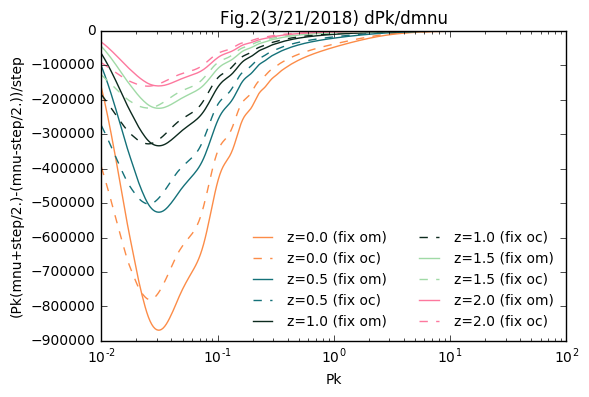

In [20]:
f,ax=subplots(1,1,figsize=(6,4))
seed(45)
for i in range(len(zcamb)):
    icolor=rand(3)
    ax.plot(kh, ds_fixom[i],'-',color=icolor,label='z=%s (fix om)'%(zcamb[i]))
    ax.plot(kh, ds_fixoc[i],'--',color=icolor,label='z=%s (fix oc)'%(zcamb[i]))
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(200,1e4)
#ax.set_ylim(-1e-9,0.5e-10)
ax.legend(loc=0,frameon=0,fontsize=10,ncol=2)
ax.set_xlabel('Pk')
ax.set_ylabel('(Pk(mnu+step/2.)-(mnu-step/2.))/step')
ax.set_title('Fig.2(3/21/2018) dPk/dmnu')
show()

In [57]:
######### using my old Fisher code
#ngal_arr = array([8.83154075745,13.2459963296,11.1471697714,7.3641882868,4.26106360488])
#Clnn =  array([0.35**2 / ngal / 1.18e7 for ngal in ngal_arr]).reshape(-1,1,1)

idx=where(ps_fidu_avg[0]!=0)

ps2 = swapaxes(ps_fidu[:,:,idx],1,2)
cov_mat = cov(ps2.reshape(-1,1000), rowvar=1) #* (2e4/12.25)
cov_inv = mat(cov_mat).I
print ps_fidu.shape, ps2.shape
print 'cov.shape',cov_mat.shape

print dcldmnu_jia.shape, dcldom_jia.shape, dcldAs_jia.shape
d1 = mat(dcldmnu_jia[:,idx].flatten())
d2 = mat(dcldom_jia[:,idx].flatten())
d3 = mat(dcldAs_jia[:,idx].flatten())
dd = [d1,d2,d3]

Fisher = zeros(shape=(3,3))
for i in range(3):
    for j in range(3):
        M = dd[i].T*dd[j] + dd[j].T*dd[i]#Na.T*Nb
        Fisher[i,j] = 0.5 * trace(cov_inv*M)
err = sqrt(mat(Fisher).I)[[0,1,2],[0,1,2]]/sqrt(2e4/12.25)
print err

(5, 1000, 50) (5, 1, 1000, 47)
cov.shape (235, 235)
(5, 50) (5, 50) (5, 50)
[ 0.00417604+0.j  0.00053055+0.j  0.00410354+0.j]


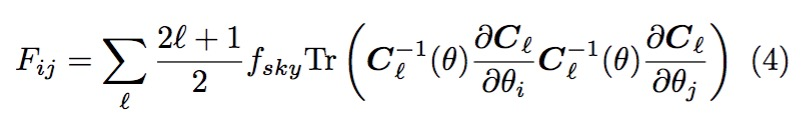

In [59]:
######### using the fisher formula Mat sent me
Image("Fisherfrommat.jpg")

In [162]:
####### using Mat's code https://arxiv.org/pdf/1402.4108.pdf
ellF = squeeze(ell_fidu[0,idx])#.flatten()
ClF = squeeze(ps_fidu_avg[:,idx])#.flatten()).I
ddF = squeeze(array([dcldmnu_jia[:,idx],dcldom_jia[:,idx],dcldAs_jia[:,idx]]))
print ellF.shape, ClF.shape, ddF.shape

dell = zeros(47)
dell[:-1] = ell_fidu[0][idx][1:48]-ell_fidu[0][idx][:46]
dell[0]=dell[1]

#print ell_fisher.shape, Cell_fisher.shape
fsky=0.5
Fisher_mat = zeros(shape=(3,3))
for i in range(3):
    for j in range(3):
        Fell = 0   
        for ie in arange(len(ellF)):
            iCl = mat(ClF[:,ie]).I
            #print iCl
            d1, d2 = mat(ddF[i,:,ie]), mat(ddF[j,:,ie])
            
            Fell += (2.*ellF[ie]+1.)/2*fsky*trace(iCl*d1*iCl*d2) * dell[ie]
           
        Fisher_mat[i,j] = Fell
        #Fisher_mat[i,j] = sum( (2.0*ellF+1.0)/2.0*fsky*trace(ClFI*dd[i]*ClFI*dd[j])*dell_arr)
        
err_mat = sqrt(mat(Fisher_mat).I)[[0,1,2],[0,1,2]]
print err_mat

(47,) (5, 47) (3, 5, 47)
[ 0.03197874+0.j  0.00282758+0.j  0.01786029+0.j]


/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in divide


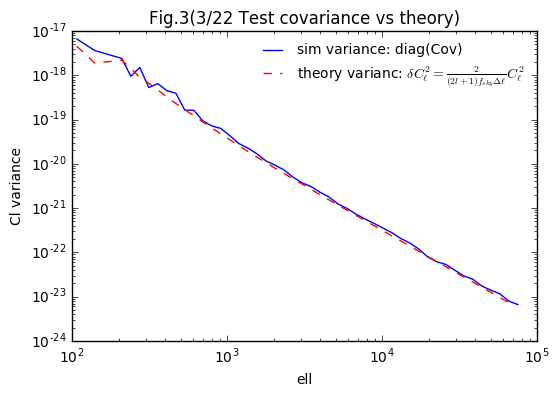

In [201]:
############# using only 1 redshift bins
#ellF = squeeze(ell_fidu[0,idx])#.flatten()
#ClF = squeeze(ps_fidu_avg[:,idx])#.flatten()).I
#ddF = squeeze(array([dcldmnu_jia[:,idx],dcldom_jia[:,idx],dcldAs_jia[:,idx]]))

id1, id2 = ddF[0][0], ddF[1][0] ## ddF shape (3, 5, 47)
iCl = squeeze(ps_fidu_avg[0,idx])## shape (5, 50)
fsim = 3.5**2/4e4

iCov = cov(squeeze(ps_fidu[0,:,idx]),rowvar=1) # ps+fidu shape (5, 1000, 50), iCov shape (47, 47)
loglog(ellF, diag(iCov),'b-',label='sim variance: diag(Cov)')
loglog(ellF, 1/(0.5*(2*ellF+1)*dell*fsim)*iCl**2, 'r--', 
       label=r'theory varianc: $\delta C_\ell^2=\frac{2}{(2l+1)f_{sky}\Delta\ell}C_\ell^2$')
title('Fig.3(3/22 Test covariance vs theory)')
xlabel('ell')
ylabel('Cl variance')
legend(fontsize=10,loc=0,frameon=0)
show()

In [ ]:
#iCov_diag = zeros(shape=iCov.shape)
#iCov_diag[diag_indices(len(id1))] = diag(iCov)
#iCovI = mat(iCov).I
#iCovdiagI = mat(iCov_diag).I
#print id1.shape, id2.shape, iCl.shape,iCov.shape

#test_mat = trace(mat(iCl).I*mat(id1)*mat(iCl).I*mat(id1))
#test_jia = trace(mat(id1)*iCovI*mat(id1).T)
#test_jiad = trace(mat(id1)*iCovdiagI*mat(id1).T)
#test_tm = sum( (2*ellF+1)*dell/2.0*id1*id1/iCl**2)

#print test_mat,test_jia, test_jiad,test_tm